## ECHR Dataset - Claim Detection results with Sentence scope

This notebook contains functions to measure the performance of a classifier applied over a set of annotations.

The output of the classification files is expected to be compatible with the output of the UKPLab models. Each line contains the token, the true label, and predicted label of one classification example, in that order, separated by tabs. The first row has the columns names. For example:

`word_n    I-Premise:2:Support    I-Premise:-1:Support`

Training results must be stored in tsv format with the following columns: epoch, modelName, dev_score, test_score, max_dev_score, max_test_score

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import pandas
import pickle
import os
import re
import seaborn as sns
from sklearn import metrics

import colors
import learning_metrics
import performance_metrics
import visualizations

In [2]:
import importlib
importlib.reload(colors)
importlib.reload(learning_metrics)
importlib.reload(performance_metrics)
importlib.reload(visualizations)

<module 'visualizations' from '/home/mteruel/am/argument_mining/evaluation/visualizations.py'>

In [3]:
CC_EXPERIMENTS_DIRS = [
#    '../../results/essays2/claim_detection/sentence/19-10-31-11-36',
#    '../../results/essays2/claim_detection/sentence/19-10-31-12-10',
#    '../../results/essays2/claim_detection/sentence/19-10-31-12-36',
#    '../../results/essays2/claim_detection/sentence/19-10-31-13-02',
#    '../../results/essays2/claim_detection/sentence/19-10-31-13-28',
#    '../../results/essays2/claim_detection/sentence/19-10-31-14-04',
#    '../../results/essays2/claim_detection/sentence/19-10-31-14-35',
#    '../../results/essays2/claim_detection/sentence/19-10-31-15-09',
#    '../../results/essays2/claim_detection/sentence/19-10-31-15-41',
#    '../../results/essays2/claim_detection/sentence/19-10-31-16-15',
#    '../../results/essays2/claim_detection/sentence/19-10-31-16-44',
#    '../../results/essays2/claim_detection/sentence/19-10-31-17-20',
#    '../../results/essays2/claim_detection/sentence/19-10-31-17-57',
#    '../../results/essays2/claim_detection/sentence/19-10-31-18-31',
#    '../../results/essays2/claim_detection/sentence/19-10-31-19-00',
#    '../../results/essays2/claim_detection/sentence/19-10-31-19-38',
#    '../../results/essays2/claim_detection/sentence/19-10-31-20-12',
#    '../../results/essays2/claim_detection/sentence/19-10-31-20-42',
#    '../../results/essays2/claim_detection/sentence/19-10-31-21-21',
#    '../../results/essays2/claim_detection/sentence/19-10-31-21-56',
#    '../../results/essays2/claim_detection/sentence/19-10-31-22-28',
#    '../../results/essays2/claim_detection/sentence/19-10-31-22-53',
#    '../../results/essays2/claim_detection/sentence/19-10-31-23-21',
#    '../../results/essays2/claim_detection/sentence/19-10-31-23-54',
#    '../../results/essays2/claim_detection/sentence/19-11-01-00-27',
#    '../../results/essays2/claim_detection/sentence/19-11-01-00-53',
#    '../../results/essays2/claim_detection/sentence/19-11-01-01-15',
#    '../../results/essays2/claim_detection/sentence/19-11-01-01-49',
#    '../../results/essays2/claim_detection/sentence/19-11-01-02-26',
#    '../../results/essays2/claim_detection/sentence/19-11-01-03-03',
#    '../../results/essays2/claim_detection/sentence/19-11-01-03-27',
#    '../../results/essays2/claim_detection/sentence/19-11-01-04-13',
#    '../../results/essays2/claim_detection/sentence/19-11-01-04-51',
#    '../../results/essays2/claim_detection/sentence/19-11-01-05-47',
#    '../../results/essays2/claim_detection/sentence/19-11-01-06-32',
#    '../../results/essays2/claim_detection/sentence/19-11-01-07-08',
#    '../../results/essays2/claim_detection/sentence/19-11-01-07-26',
#    '../../results/essays2/claim_detection/sentence/19-11-01-07-59',
#    '../../results/essays2/claim_detection/sentence/19-11-01-08-51',
#    '../../results/essays2/claim_detection/sentence/19-11-01-09-39',
#    '../../results/essays2/claim_detection/sentence/19-11-01-11-13',
#    '../../results/essays2/claim_detection/sentence/19-11-01-12-46',
#    '../../results/essays2/claim_detection/sentence/19-11-01-14-08',
#    '../../results/essays2/claim_detection/sentence/19-11-01-15-36',
#    '../../results/essays2/claim_detection/sentence/19-11-01-17-16',
#    '../../results/essays2/claim_detection/sentence/19-11-01-18-55',
#    '../../results/essays2/claim_detection/sentence/19-11-01-19-56',
#    '../../results/essays2/claim_detection/sentence/19-11-01-21-03',
#    '../../results/essays2/claim_detection/sentence/19-11-01-21-43',
#    '../../results/essays2/claim_detection/sentence/19-11-01-22-22',
#    '../../results/essays2/claim_detection/sentence/19-11-01-23-26',
#    '../../results/essays2/claim_detection/sentence/19-11-02-00-41',
#    '../../results/essays2/claim_detection/sentence/19-11-02-01-50',
#    '../../results/essays2/claim_detection/sentence/19-11-02-02-52',
#    '../../results/essays2/claim_detection/sentence/19-11-02-03-37',
    # Self attention
#        '../../results/essays2/claim_detection/sentence/19-11-02-04-52',
#    '../../results/essays2/claim_detection/sentence/19-11-02-05-10',
#    '../../results/essays2/claim_detection/sentence/19-11-02-05-47',
#    '../../results/essays2/claim_detection/sentence/19-11-02-06-06',
#    '../../results/essays2/claim_detection/sentence/19-11-02-06-27',
#    '../../results/essays2/claim_detection/sentence/19-11-02-06-48',
#    '../../results/essays2/claim_detection/sentence/19-11-02-07-02',
#    '../../results/essays2/claim_detection/sentence/19-11-02-07-25',
#    '../../results/essays2/claim_detection/sentence/19-11-02-08-03',
#    '../../results/essays2/claim_detection/sentence/19-11-02-08-23',
#    '../../results/essays2/claim_detection/sentence/19-11-02-08-40',
#    '../../results/essays2/claim_detection/sentence/19-11-02-09-16',
#    '../../results/essays2/claim_detection/sentence/19-11-02-09-45',
#    '../../results/essays2/claim_detection/sentence/19-11-02-10-06',
#    '../../results/essays2/claim_detection/sentence/19-11-02-10-35',
#    '../../results/essays2/claim_detection/sentence/19-11-02-11-06',
#    '../../results/essays2/claim_detection/sentence/19-11-02-11-38',
#    '../../results/essays2/claim_detection/sentence/19-11-02-11-58',
#    '../../results/essays2/claim_detection/sentence/19-11-02-12-27',
#    '../../results/essays2/claim_detection/sentence/19-11-02-12-44',
#    '../../results/essays2/claim_detection/sentence/19-11-02-12-59',
#    '../../results/essays2/claim_detection/sentence/19-11-02-13-23',
#    '../../results/essays2/claim_detection/sentence/19-11-02-13-52',
#    '../../results/essays2/claim_detection/sentence/19-11-02-14-08',
#    '../../results/essays2/claim_detection/sentence/19-11-02-14-42',
#    '../../results/essays2/claim_detection/sentence/19-11-02-14-58',
#    '../../results/essays2/claim_detection/sentence/19-11-02-15-17',
#    '../../results/essays2/claim_detection/sentence/19-11-02-15-38',
#    '../../results/essays2/claim_detection/sentence/19-11-02-15-53',
#    '../../results/essays2/claim_detection/sentence/19-11-02-16-16',
#    '../../results/essays2/claim_detection/sentence/19-11-02-16-39',
#    '../../results/essays2/claim_detection/sentence/19-11-02-16-56',
    '../../results/essays2/claim_detection/sentence/19-11-04-18-10',
    '../../results/essays2/claim_detection/sentence/19-11-04-19-29',
    '../../results/essays2/claim_detection/sentence/19-11-04-20-58',
    '../../results/essays2/claim_detection/sentence/19-11-04-21-58',
    '../../results/essays2/claim_detection/sentence/19-11-04-22-53',
    '../../results/essays2/claim_detection/sentence/19-11-05-00-20',
    '../../results/essays2/claim_detection/sentence/19-11-05-01-22',
]

## Classification Results

In [4]:
cc_results = performance_metrics.architecture_metrics(CC_EXPERIMENTS_DIRS)

DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']
DEBUG: classes used ['O' 'I-Claim']


In [5]:
cc_results[cc_results.Dataset == 'dev']

,Classifier,Dataset,Accuracy,Precision,Recall,F1-Score,Support
0,19-11-04-18-10,dev,0.832600,0.752770,0.753344,0.753056,14767
0,19-11-04-19-29,dev,0.823796,0.740269,0.748526,0.744210,14767
1,19-11-04-20-58,dev,0.836934,0.763824,0.724170,0.740329,14767
1,19-11-04-21-58,dev,0.840523,0.773383,0.719298,0.739858,14767
1,19-11-04-22-53,dev,0.834225,0.758677,0.722215,0.737257,14767
1,19-11-05-00-20,dev,0.833412,0.758158,0.716924,0.733456,14767
0,19-11-05-01-22,dev,0.837611,0.773834,0.701075,0.725750,14767


### Comparison between classifiers

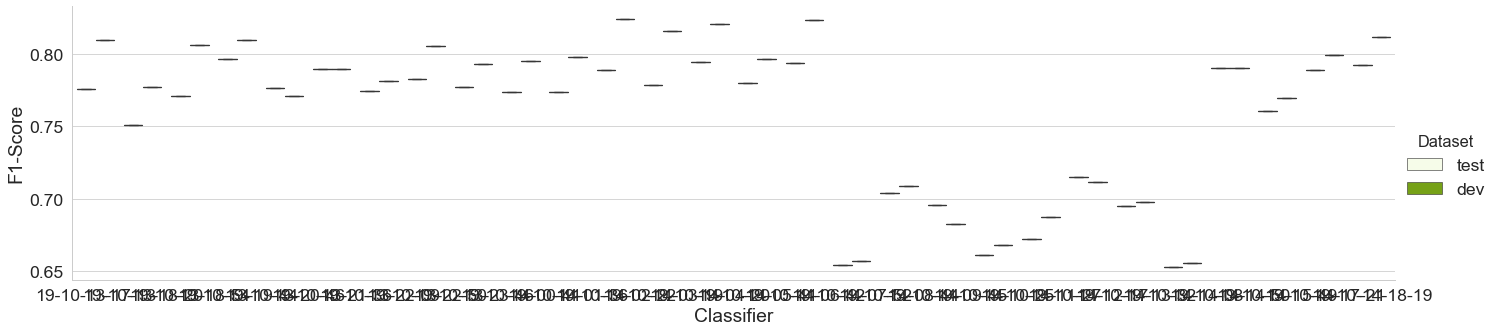

In [8]:
sns.catplot(data=cc_results,
            x='Classifier', kind='box', y='F1-Score', hue='Dataset',
            aspect=4, height=5, color=colors.green)

## Learning rate

In [ ]:
cc_learning = learning_metrics.architecture_learning(CC_EXPERIMENTS_DIRS)
cc_learning[:4]

In [ ]:
hyperparameters = pandas.read_csv('../../results/ukpnets/echr_classifiers.tsv', sep='\t',
                                  usecols=['Name', 'Time/Feature', 'Activation', 'Attention'])
hyperparameters = hyperparameters.rename(columns={'Time/Feature': 'Attention type', 'Name': 'Classifier'})
hyperparameters = hyperparameters.replace(
    to_replace=['Word', 'Context'], value=['Word attention', 'Context attention'])
hyperparameters['Attention type'] = hyperparameters['Attention type'].replace('None', 'No attention')
hyperparameters['Activation'] = hyperparameters['Activation'].replace('None', 'Linear')
hyperparameters[:3]

In [ ]:
cc_learning = cc_learning.join(hyperparameters.set_index('Classifier'), on='Classifier')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(data=cc_learning[(cc_learning.Classifier == '19-08-28-13-30')],
              x='epoch', y='Metric Value', hue='Dataset',
              aspect=6, join=True,
              color=colors.red, ax=ax)
# Set xticks every 5 elements
labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%5 != 0): labels[i] = '' # skip even labels
ax.set_xticklabels(labels); # set new labels

### Confusion matrix

              precision    recall  f1-score   support

     I-Claim       0.62      0.64      0.63      3188
           O       0.90      0.89      0.90     11579

   micro avg       0.84      0.84      0.84     14767
   macro avg       0.76      0.77      0.76     14767
weighted avg       0.84      0.84      0.84     14767



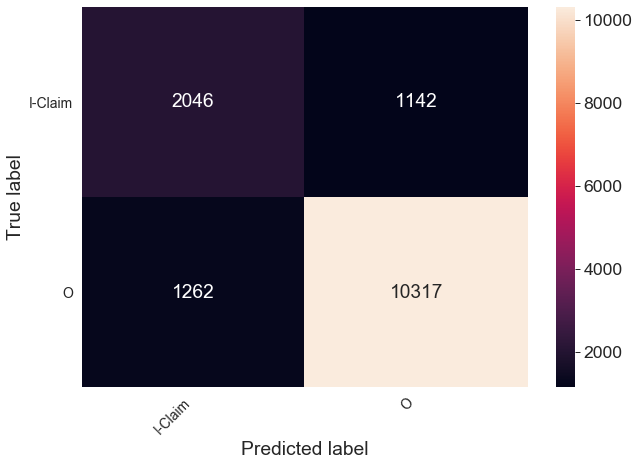

In [3]:
performance_metrics.plot_confusion_matrix(
    '../../results/essays2/claim_detection/sentence/19-10-31-23-21')

---

# Classifier variance

In [6]:
classifiers = pandas.read_csv('../../results/essays_claim_detection_sentence.tsv', sep='\t')
classifiers['Attention type'] = classifiers['Attention type'].replace('None', 'No Attention')\
  .replace('time_pre', 'Word Attention').replace('feature_pre', 'Context Attention')
classifiers['Activation'] = classifiers['Activation'].replace('None', 'linear').replace('Sigmoid', 'sigmoid').fillna('na')

In [7]:
classifiers[:5]

,Name,Accuracy,Precision,Recall,F1-Score,Attention type,Activation,Heads,Attention size,Char embed,Char embed size,Last layer,Layers,Dropouts,Batch Size
0,19-10-31-11-36,0.845,0.782,0.728,0.749,No Attention,linear,NaN,NaN,lstm,32,Softmax,100,0.4,100
1,19-10-31-12-10,0.838,0.764,0.737,0.748,No Attention,linear,NaN,NaN,lstm,16,Softmax,30,0.2,50
2,19-10-31-12-36,0.831,0.752,0.730,0.740,No Attention,linear,NaN,NaN,lstm,64,CRF,30,0.3,50
3,19-10-31-13-02,0.826,0.744,0.758,0.750,No Attention,linear,NaN,NaN,lstm,64,CRF,50,0.1,50
4,19-10-31-13-28,0.843,0.774,0.731,0.749,No Attention,linear,NaN,NaN,cnn,32,Softmax,200,0.4,200


In [8]:
classifiers.Activation.unique()

array(['linear', 'tanh', 'sigmoid', 'na'], dtype=object)

## Comparing attention mechanisms

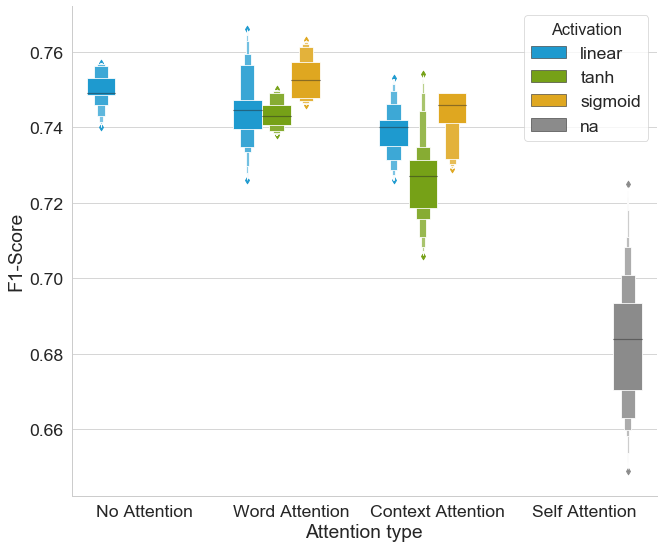

In [9]:
sns.catplot(data=classifiers, kind='boxen',
            y='F1-Score', x='Attention type', hue='Activation',
            height=8, aspect=1.2, legend_out=False, palette=visualizations.activation_palette)

(0.5, 0.85)

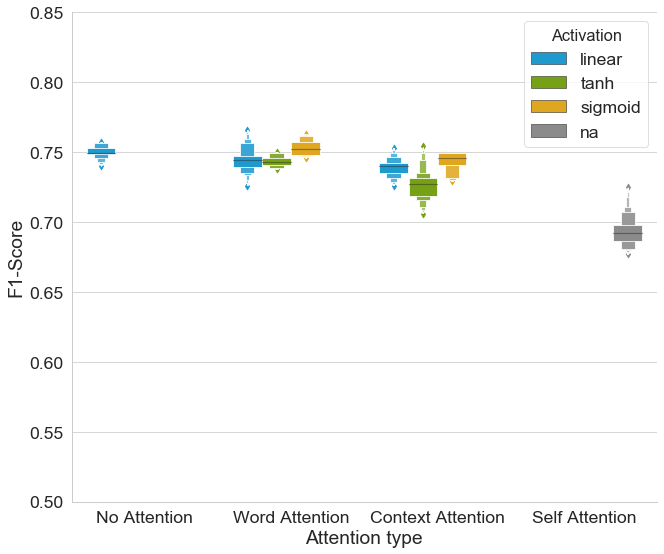

In [10]:
sns.catplot(data=classifiers[(classifiers.Heads != 1) & (classifiers.Heads != 2)],
            kind='boxen',
            y='F1-Score', x='Attention type', hue='Activation',
            height=8, aspect=1.2, legend_out=False, palette=visualizations.activation_palette)
plt.ylim((0.5, 0.85))

In [11]:
visualizations.att_palette.keys()

dict_keys(['No Attention', 'Word Attention', 'Context Attention', 'Self Attention', 'Bert'])

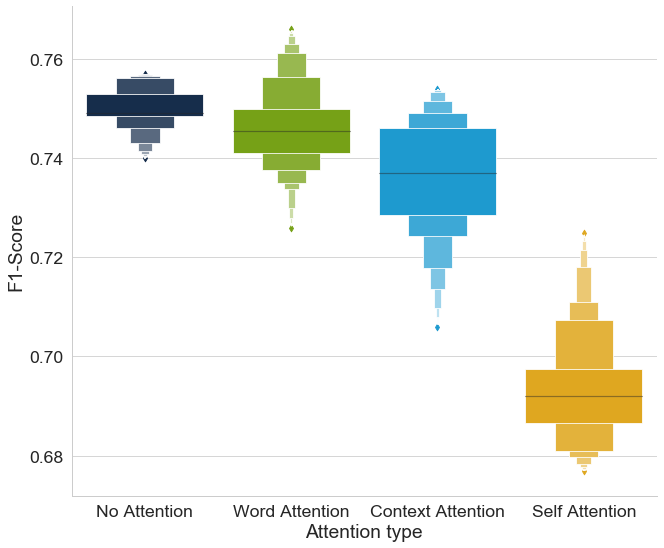

In [12]:
sns.catplot(data=classifiers[(classifiers.Heads != 1) & (classifiers.Heads != 2)], kind='boxen',
            y='F1-Score', x='Attention type', aspect=1.2,
            height=8, legend_out=False, palette=visualizations.att_palette)

In [ ]:
sns.catplot(data=classifiers, kind='boxen',
            y='F1-Score', x='Attention type', aspect=1.2,
            height=8, legend_out=False, palette=visualizations.att_palette)

In [14]:
sns.catplot(data=classifiers, kind='boxen',
            y='F1-Score', x='LSTM layer size',  # hue='Attention type',
            height=8, legend_out=False, color=colors.blue)

ValueError: Could not interpret input 'LSTM layer size'

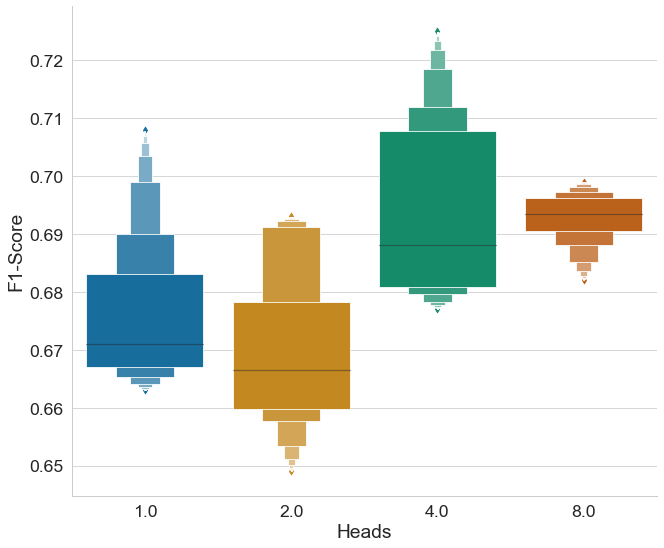

In [13]:
sns.catplot(data=classifiers[classifiers['Attention type'] == 'Self Attention'], kind='boxen',
            y='F1-Score', x='Heads', aspect=1.2,
            height=8, legend_out=False)